## Data Preparation Pipeline (CoughVid)

This notebook prepares the CoughVid dataset for training by applying a series of cleaning, filtering, and transformation steps.

The dataset can be obtained from here: https://zenodo.org/records/7024894.

Note:
- The code below has been configured to run on Google colab with python scripts imported from Google Drive. All helper files can be found under data_preparation folder.
- All output in this notebook are provided for your reference. This is to help you know how it should look like after running the various functions. Outputs were based on a small sammple to ensure helper functions were working properly and not representative of the full output when working with the entire dataset. 

Pipeline Summary:

0. Mount Google Drive
1. (Skipped) Data Download and Extraction (Coughvid)
2. (Skipped) Prepare Metadata / Labels (Coughvid)
3. Convert and Copy Raw Audio
4. Process Audio Files
5. Train-Test Split and Label Alignment
6. Data Integrity Check

### 0. Mount Google Drive

- This step handles mounting Drive and ensuring access scripts and datasets stored in your Drive.
- Accompanying helper file: step1_get_zip.py

In [ ]:
# Mount Google Drive to access files
# This code is intended to be run in Google Colab
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# To run this notebook, you need to cd to the folder where the helper files are located.
# You can do this by running the following command:
%cd /content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/py_util/

/content/drive/.shortcut-targets-by-id/1UBr7xHwiaUCT4Y9U0LH_0qJJfCYxNbgT/AML/Dataprep/test_dataprep_for_github/py_util


In [ ]:
# As backup, to use the helper files, we add its path to the system path
# This is not necessary if you are already in the correct directory.
# You can comment this line out if you are already in the correct directory.
import sys
sys.path.append('/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/py_util')

In [ ]:
# Importing the function to check if the drive is mounted, and to mount it if not
from step1_get_zip import mount_drive
mount_drive()

Google Drive already mounted.


Expected Output:
- Google Drive mounted
- Able to access helper files

### 1. (Skipped) Data Download and Extraction (CoughVid)

- This step handles downloading and extracting the raw CoughVid dataset for first-time users or full reproducibility.
- Source: Public dataset hosted on Zenodo: https://zenodo.org/record/7024894
    - Download the file: public_dataset_v3.zip
- Contents of the zip archive:
    - A folder named coughvid_20211012/ containing:
        - .webm, .ogg, and .wav files — raw audio recordings
        - .json files — metadata annotations (not required in this project)
    - Filenames are UUID-style and repeated across file types:
        - e.g., abc123.wav, abc123.webm, abc123.json
- What is required:
    - Only the audio files (.webm, .wav) will be used in the downstream audio processing pipeline
    - .json files can be ignored
- How to extract:
    - Use the helper function extract_zip_to_directory() from the script step1_get_zip.py
    - Handles safe unzip to a specified folder
    - Creates the coughvid_20211012/ directory automatically
- Accompanying helper file: step1_get_zip.py
- Note: This notebook skips the raw extraction step because audio files were pre-prepared. To reproduce the dataset from scratch, run the helper script manually in Colab or locally

In [ ]:
# Importing the function to unzip the downloaded ZIP file
import os

# Define path to the ZIP file you downloaded from Zenodo
# This is the path to the ZIP file in your Google Drive
# Make sure to replace this with the actual path to your ZIP file
# The path should be in the format "/content/drive/MyDrive/your_folder/your_file.zip"
zip_path = "/content/drive/MyDrive/AML/Data/dataset2_coughvid/public_dataset_v3.zip"

# This is the path where you want to extract the contents of the ZIP file
# Make sure to replace this with the actual path where you want to extract the files
# The path should be in the format "/content/drive/MyDrive/your_folder/extracted_folder"
extract_to = "/content/drive/MyDrive/AML/Data/dataset2_coughvid/public_dataset_v3_unzipped"

In [ ]:
# Importing the function to extract the ZIP file
from step1_get_zip import extract_zip_to_directory

# Extract the contents of the zip file to the target folder
extract_zip_to_directory(zip_path, extract_to)

Expected Output:
- A directory named coughvid_20211012/ is created in your working environment
- Inside this folder:
    - Audio files:
        - .wav and/or .webm recordings named by UUID
        - Used as input for filtering, conversion, and modeling
    - Metadata files:
        - .json files that can be ignored for this pipeline
- Example of a typical file pair:
    - 00014dcc-0f06-4c27-8c7b-737b18a2cf4c.webm
    - 00014dcc-0f06-4c27-8c7b-737b18a2cf4c.json
- Outcome:
    - You now have all raw audio files locally available for processing (Step 3 onward)
    - The structure is clean and ready for audio filtering, conversion, and labeling steps.
- Note: This notebook skips the raw extraction step because audio files were pre-prepared. To reproduce the dataset from scratch, run the helper script manually in Colab or locally

### 2.  (Skipped) Prepare Metadata / Labels for Coughvid

- This step extracts and cleans the CoughVid metadata to generate binary health labels that align with available audio files, making the data suitable for machine learning tasks.
- Source: Raw metadata CSV file (e.g., metadata_compiled.csv)
    - Contains fields such as:
        - cough_detected: confidence score that the sample contains a cough
        - diagnosis_1 to diagnosis_4: expert-provided health labels per recording
- Label processing pipeline:
    - Filter by quality: Retain only samples where cough_detected ≥ 0.8
    - Filter by diagnosis: Keep only samples with exactly one non-null diagnosis
    - Map diagnoses into binary format:
        - healthy_cough → 1 (Healthy)
        - upper_infection, lower_infection, obstructive_disease, COVID-19 → 0 (Not Healthy)
- Verify audio file existence: Only keep entries where a matching .webm or .wav file exists in the audio folder (e.g., coughvid_20211012/)
- Accompanying helper file: step2_prepare_metadata.py
- Note: This notebook skips the raw extraction step because audio files were pre-prepared. To reproduce the dataset from scratch, run the helper script manually in Colab or locally

In [ ]:
# Importing the function to load the metadata
import os
import pandas as pd

# Import helper functions from step2_prepare_metadata.py
from step2_prepare_metadata import (
    load_raw_metadata,
    filter_coughvid_high_quality,
    combine_coughvid_expert_labels,
    keep_only_existing_audio_files,
    save_labels_csv
)

In [ ]:
# Define paths
# Path to the raw metadata CSV (provided in the Zenodo zip)
metadata_csv_path = "/content/drive/MyDrive/AML/Data/dataset2_coughvid/metadata_compiled.csv"

# Path to directory containing audio files (after extracting public_dataset_v3.zip)
audio_dir = "/content/drive/MyDrive/AML/Data/dataset2_coughvid/public_dataset_v3_unzipped"

# Output path for cleaned label CSV
output_label_csv = "/content/drive/MyDrive/AML/Data/dataset2_coughvid/data_labels_coughvid.csv"

In [ ]:
# Load the raw metadata into a pandas DataFrame
df_raw = load_raw_metadata(metadata_csv_path)

# Filter for high-quality coughs only (confidence >= 0.8)
df_high_quality = filter_coughvid_high_quality(df_raw, min_confidence=0.8)

# The function combine_coughvid_expert_labels will create binary labels from diagnosis_1 to diagnosis_4 
# for each diagnosis column and combine them into a single DataFrame.
diagnosis_columns = ['diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'diagnosis_4']
df_labeled = combine_coughvid_expert_labels(df_high_quality, diagnosis_columns)

# Keep only entries for which the actual audio file (.webm or .wav) exists
df_audio_available = keep_only_existing_audio_files(df_labeled, audio_dir)

In [ ]:
# The function save_labels_csv is defined in step2_prepare_metadata.py
# Save the cleaned DataFrame to a CSV file
save_labels_csv(df_audio_available, output_label_csv)

# Print the shape of the cleaned DataFrame and the first few rows
# This is useful for debugging and ensuring the data is as expected
print("\nClean label CSV created with shape:", df_audio_available.shape)
print(df_audio_available.head())

Expected Output:
- A cleaned label CSV file, typically named data_labels_coughvid.csv, with the following properties:
- Columns:
    - uuid: unique ID corresponding to each audio file
    - health_status: binary label
        - 1 = Healthy (healthy_cough)
        - 0 = Not Healthy (upper_infection, lower_infection, obstructive_disease, COVID-19)
- Filters applied:
    - cough_detected ≥ 0.8
    - Only one diagnosis present per sample
    - Audio file (.webm or .wav) must exist in the dataset directory
- Purpose:
    - Acts as the ground truth label file
    - Used in all downstream steps (e.g., audio extraction, train-test split, modeling) for the CoughVid dataset
- Note: This notebook skips the raw extraction step because audio files were pre-prepared. To reproduce the dataset from scratch, run the helper script manually in Colab or locally

### 3. Convert and Copy Raw Audio

- This step prepares the audio files for modeling by extracting them from a mixed-format dataset, converting them to .wav format, and saving them in a clean, standardized folder.
- Uses filenames from a label CSV to extract matching audio files
    - Auto-detects the ID column (e.g., filename, uuid, id, etc.)
    - Strips file extensions to ensure consistent matching
- Searches for audio files in common formats:
    - .webm, .ogg, .mp3, .flac, .aac, .m4a, .opus, and .wav
    - Prioritizes .webm and .wav as common formats in COUGHVID
- Conversion and cleanup:
    - Converts all non-.wav formats to .wav using pydub and ffmpeg
    - Deletes the original non-.wav files after successful conversion
    - Ensures only final .wav files remain in the output folder
- Organizes processed files in a new folder
    - Clean flat structure: filenames follow UUID-style (e.g., abc123.wav)
    - Audio files are aligned with label entries from the CSV
- Accompanying helper file: step3_select_audio.py

In [ ]:
# Install pydub for audio processing
!pip install pydub

In [ ]:
# Importing the function to convert and copy audio files
from step3_select_audio import load_label_csv, copy_and_convert_audio_files_coughvid

# Define paths for audio conversion
# Path to the cleaned label CSV file (output from the previous step)
# Path to the raw audio files directory (after extracting public_dataset_v3.zip) (this is the same as the audio_dir variable above)
# Path to the directory where converted audio files will be saved (this directory will be created if it doesn't exist)
label_csv_path = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_raw_data_labels_coughvid.csv"
raw_audio_dir = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_coughvid_raw"
converted_audio_dir = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_coughvid_raw_converted"

# Load the label CSV file into a DataFrame
id_list = load_label_csv(label_csv_path)

# Copy and convert audio files from the raw directory to the converted directory
# The function will create the converted directory if it doesn't exist
copy_and_convert_audio_files_coughvid(id_list, raw_audio_dir, converted_audio_dir)

Loaded 50 entries from /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_raw_data_labels_coughvid.csv using column 'filename'
Copied 50 files to /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_coughvid_raw_converted
Missing files: 0
Converted: 977592cb-c1f2-4b5e-bad1-6132b5cd2ad0.webm to 977592cb-c1f2-4b5e-bad1-6132b5cd2ad0.wav
Converted: bbb221cc-8c5c-407d-9ae1-ae8ebd842504.webm to bbb221cc-8c5c-407d-9ae1-ae8ebd842504.wav
Converted: 5fb358c3-76bc-4adc-93ac-02f367e38739.webm to 5fb358c3-76bc-4adc-93ac-02f367e38739.wav
Converted: 2499bd0e-4221-449a-8184-ee15e1c80b35.webm to 2499bd0e-4221-449a-8184-ee15e1c80b35.wav
Converted: c261cdbc-fb1e-4444-8b68-33c920047d8c.webm to c261cdbc-fb1e-4444-8b68-33c920047d8c.wav
Converted: ffedc843-bfc2-4ad6-a749-2bc86bdac84a.webm to ffedc843-bfc2-4ad6-a749-2bc86bdac84a.wav
Converted: edcadaac-51d0-44d1-99c6-efbbc41dd4bd.ogg to edcadaac-51d0-44d1-99c6-efbbc41dd4bd.wav
Converted: 3b018a2b-59a9-484b-a71e-437fb96698ab.w

Expected Output:
- A new folder (e.g., coughvid_raw_converted/) is created, containing:
    - Only .wav files
    - Filenames matching the UUIDs in the label CSV (e.g., 00014dcc.wav)
- File processing summary:
    - Number of files successfully copied from the source
    - Number of files converted to .wav from other formats
    - Number of missing files (IDs in the CSV not found in the source folder)
- Final state:
    - All files are standardized in .wav format
    - No leftover .webm, .ogg, or unsupported files
    - Folder is ready for downstream preprocessing (e.g., denoising, silence trimming, model training)

### 4. Process Audio Files

This step enhances the quality and consistency of audio samples to make them suitable for machine learning models. It applies a full preprocessing pipeline to raw .wav files.
- Purpose:
    - To standardize and clean audio files for robust training/testing of models.
    - Remove noise and variability due to different recording conditions.
- Key processing steps:
    - Signal-to-Noise Ratio (SNR) Filtering: Filters out poor-quality recordings with low SNR to retain only clear cough sounds.
    - Resampling: Resamples all audio to a standard sample rate (e.g., 16 kHz) for model compatibility.
    - Denoising: Applies noise reduction techniques (e.g., spectral gating, Non-Local Means) to reduce background noise.
    - Silence Trimming: Automatically removes silent segments at the beginning and end of the recording to isolate the cough signal.
- Batch Processing: Processes all files in a given folder (e.g., *_converted) and saves outputs into a new directory (e.g., *_processed).
- Accompanying helper file: step4_process_audio.py
    - Contains the pipeline logic via process_and_save_dataset() function.

In [ ]:
# Install noisereduce for noise reduction procesesing component
!pip install noisereduce

In [ ]:
# Importing the function to process and save the dataset
from step4_process_audio import process_and_save_dataset

# Define paths for the input and output folders
# Input folder containing the converted audio files
# This should be the same as the converted_audio_dir from the previous step
# Output folder where the processed audio files will be saved
# This folder will be created if it doesn't exist
# Make sure to change the paths according to your directory structure
input_folder = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_coughvid_raw_converted"
output_folder = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_coughvid_processed"

# Run the processing pipeline
# This will process the audio files in the input folder and save them to the output folder
process_and_save_dataset(input_folder, output_folder)

Saved: /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_coughvid_processed/01723b00-382f-4089-a7c3-9c90b3ddad17.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_coughvid_processed/00bf9f83-2e8f-47cf-a4f2-97f2beceebc1.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_coughvid_processed/977592cb-c1f2-4b5e-bad1-6132b5cd2ad0.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_coughvid_processed/bbb221cc-8c5c-407d-9ae1-ae8ebd842504.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_coughvid_processed/5fb358c3-76bc-4adc-93ac-02f367e38739.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_coughvid_processed/2499bd0e-4221-449a-8184-ee15e1c80b35.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_coughvid_processed/c261cdbc-fb1e-4444-8b68-33c920047d8c.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_

Expected Output:
- A new folder (e.g., fortest_coughvid_processed/) containing:
    - .wav files that have been cleaned and standardized
    - One file per input sample (matching the same UUIDs or filenames)
- All files should now:
    - Have a consistent duration and sample rate
    - Be denoised and trimmed
    - -Be smaller in size and better in quality than the originals
- The total number of output files will match or be fewer than the input files (some may be dropped during filtering).

### 5. Train-Test Split and Label Alignment

- This step prepares your final dataset structure for model training and evaluation by aligning cleaned audio with labels, splitting the data, and organizing it clearly.
- Purpose:
    - Ensure that each processed audio file has a corresponding binary label (health_status).
    - Split the dataset into training and testing sets while maintaining the label distribution.
- Key steps:
    - Label Alignment:
        - Matches each .wav file in the processed audio folder to its corresponding label from the cleaned metadata CSV.
        - Only audio files that have both a label and a valid processed .wav file are retained.
    - Stratified Train-Test Split:
        - Splits data into training and test sets (e.g., 80/20) with equal class distribution (health_status = 0/1).
        - Ensures fair and balanced evaluation.
    - File Organization:
        - Copies the .wav files into separate folders:
            - e.g., fortest_coughvid_train/ and fortest_coughvid_test/
        - Creates accompanying CSVs:
            - fortest_train_labels.csv, fortest_test_labels.csv
            - Each contains: filename, health_status
- Accompanying helper file: step5_split_and_label.py

In [ ]:
# Importing the function to split and label the dataset
from step5_split_and_label import full_pipeline

# Define paths for the processed audio directory, original labels CSV, output labels CSV, and train/test folders
# These paths should be updated according to your directory structure
# Processed audio directory containing the processed audio files
# Original labels CSV file (output from the previous step)
# Output labels CSV file where the processed labels will be saved
# Train and test folders where the split audio files will be saved
# Train and test CSV paths for saving the split labels
# ID column name (if any) to be used for splitting the dataset
# If you don't have an ID column, set this to None
processed_audio_dir = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_coughvid_processed"

original_labels_csv = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_raw_data_labels_coughvid.csv"
output_labels_csv = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_processed_data_labels_coughvid.csv"

train_csv_path = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_train_labels_coughvid.csv"
test_csv_path = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_test_labels_coughvid.csv"

train_folder = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_coughvid_train"
test_folder = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_coughvid_test"

# Run the full pipeline to split and label the dataset
full_pipeline(
    processed_audio_dir=processed_audio_dir,
    original_labels_csv=original_labels_csv,
    output_labels_csv=output_labels_csv,
    train_folder=train_folder,
    test_folder=test_folder,
    train_csv_path=train_csv_path,
    test_csv_path=test_csv_path,
    id_column=None
)

Found 50 processed audio files
Detected ID column: 'filename'

Summary of Label Distribution:
- Matched Files: 50
- Healthy: 25
- Not Healthy: 25
- New labels CSV saved to: /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_processed_data_labels_coughvid.csv
Detected ID column: 'filename'

Train-test split complete:
- Train labels saved to: /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_train_labels.csv (40 rows)
- Test labels saved to: /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_test_labels.csv (10 rows)
Copied 40/40 files to /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_coughvid_train
Copied 10/10 files to /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_coughvid_test

Labeling and train/test split complete.
Train audio files saved to: /content/drive/MyDrive/AML/Dataprep/test_dataprep_for_github/fortest_coughvid_train
Test audio files saved to: /content/drive/MyDrive/AML/Datapr

Expected Output:
- Two folders:
    - fortest_coughvid_train/ – contains training .wav files (or according to your folder name)
    - fortest_coughvid_test/ – contains testing .wav files (or according to your folder name)
- Two CSVs:
    - fortest_train_labels.csv – labels for training files (or according to your csv name)
    - fortest_test_labels.csv – labels for testing files (or according to your csv name)
- All files are guaranteed to have valid audio and a corresponding label.

### 6. Data Integrity Check

- This final step ensures that your dataset is clean, consistent, and ready for modeling. It acts as a validation gate to catch any mismatches or missing files before training begins.
- Purpose:
    - Validate that the .wav files in the train/test folders match the filenames listed in their respective label CSVs.
    - Check for missing or extra files.
    - Confirm that label values are within the expected range (e.g., only 0 or 1).
    - Verify balanced distribution of labels.
- Key checks performed:
    - File existence: Confirms every filename listed in the CSV actually exists in the folder.
    - CSV validity: Ensures the health_status column is present and contains valid values (0 or 1).
    - Label distribution: Outputs a quick summary of class distribution (e.g., 50% healthy, 50% not healthy). Helps catch class imbalance early.
    - Sample listing: Displays a few filenames and their labels to visually inspect correctness.
- Accompanying helper file: step6_check_dataset.py

Total Train Files: 40
Sample Train Files: ['d1fd16e4-258e-4b20-9978-d0f6106b1d22.wav', 'bc048378-1d7f-44ed-a8a8-e2ce7d0a56ae.wav', 'e8fe6b8b-a7be-404d-95a5-5da7f4efe0e8.wav', '2499bd0e-4221-449a-8184-ee15e1c80b35.wav', 'beb9eff3-e2c7-4f53-981b-0abc09158dec.wav', '4b46da7b-b391-45f6-925a-9aa31eb5b58a.wav', '15a0a034-354e-4637-b74c-9653763e0862.wav', 'd5ae4279-5716-4658-ba24-8cb5cf87f40d.wav', '306d3ace-9b3b-4285-ba5c-86b0797987c9.wav', '881d892d-f3a9-4409-82d3-1f43c7ce5047.wav']
Total Test Files: 10
Sample Test Files: ['4a19eff2-8302-4aa6-9164-ae5a9d2d824f.wav', '28d173a5-6b04-4c7b-8b29-84e670dc6c35.wav', '9cefcba6-bea1-4131-a905-3d28e567344b.wav', '5b2342d2-01f8-4ad7-bf13-217601cd3c13.wav', '47edb277-7f3c-426d-8e14-a0385f3c1b77.wav', 'a31d884f-23d8-4098-ba48-09daca06c116.wav', '00bf9f83-2e8f-47cf-a4f2-97f2beceebc1.wav', 'f871f11b-c593-4d30-b683-f9ba565088e5.wav', 'd70748e6-0e82-4760-a2fc-d63b01d3c65c.wav', '8a3058b7-c1ec-43d8-ae17-f1c72da07a21.wav']
✅ Detected ID column: 'filename'
Uni

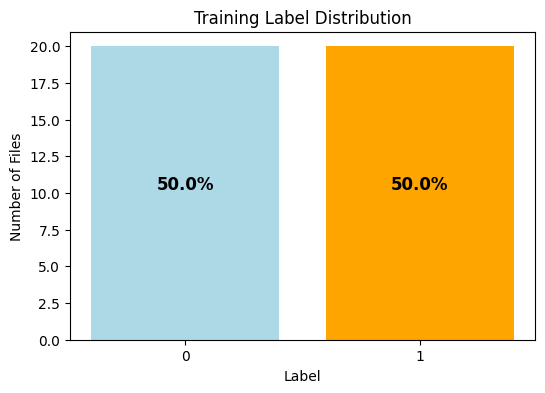

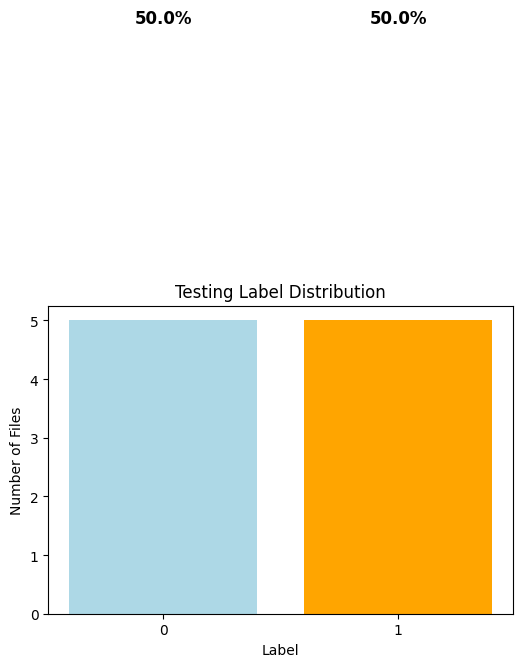

Skipped 0 files due to errors.
Skipped 0 files due to errors.

Training Data: 40 samples
Test Data: 10 samples

Sample training shapes:
d1fd16e4-258e-4b20-9978-d0f6106b1d22.wav: (17920,)
bc048378-1d7f-44ed-a8a8-e2ce7d0a56ae.wav: (31232,)
e8fe6b8b-a7be-404d-95a5-5da7f4efe0e8.wav: (29696,)
2499bd0e-4221-449a-8184-ee15e1c80b35.wav: (9216,)
beb9eff3-e2c7-4f53-981b-0abc09158dec.wav: (96256,)

Sample test shapes:
4a19eff2-8302-4aa6-9164-ae5a9d2d824f.wav: (73216,)
28d173a5-6b04-4c7b-8b29-84e670dc6c35.wav: (39424,)
9cefcba6-bea1-4131-a905-3d28e567344b.wav: (34816,)
5b2342d2-01f8-4ad7-bf13-217601cd3c13.wav: (84480,)
47edb277-7f3c-426d-8e14-a0385f3c1b77.wav: (49152,)


In [ ]:
from step6_check_dataset import run_check_pipeline

train_csv_path = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_train_labels_coughvid.csv"
test_csv_path = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_test_labels_coughvid.csv"

train_folder = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_coughvid_train"
test_folder = "/content/drive/MyDrive/AML/Dataprep/test_coughvid_dataprep_for_github/fortest_coughvid_test"

run_check_pipeline(
    train_dir=train_folder,
    test_dir=test_folder,
    train_labels_path=train_csv_path,
    test_labels_path=test_csv_path
)

Expected Output:
- A printed report with:
    - Total number of files in each split (train and test)
    - Sample filenames and their health_status from the CSV
    - Unique label values detected and their counts
    - Confirmation that all listed files exist and are labeled
- Visual: Bar plot showing class distribution in the training set
- Assurance that the data is clean, aligned, and balanced before training begins.